In [2]:
import zipfile
import scipy.io
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import mne
import shutil

## Deal with PLI
In the original work, they removed PLI as the network didn't seem to perform well. They assign a different class to the powerline noise of 60 Hz and 50 Hz. I will just change all the labels to 'powerline' or 'noise'.

In [2]:
inputZip = '/home/mcesped/scratch/Datasets/Dataset_Fnusa.zip'
path_to_segments = 'DATASET_FNUSA/segments.csv'

In [77]:
with zipfile.ZipFile(inputZip, mode="r") as archive:
    files= archive.namelist()
    with archive.open(path_to_segments) as myfile:
        df = pd.read_csv(myfile, sep=',', index_col='index')

In [80]:
reg = re.compile("y000002")
list(filter(reg.search, files)) 

['DATASET_FNUSA/y000002.mat']

In [26]:
# scipy.io.loadmat(data)

In [56]:
df[df['category_id']==0]

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
index,,,,,,,,,,
0,gyrus lingualis,0,D1,depth,fnusa,0,1,y000000,0,powerline_50hz
1,gyrus lingualis,0,D1,depth,fnusa,0,1,y000001,0,powerline_50hz
2,gyrus lingualis,0,D1,depth,fnusa,0,1,y000002,0,powerline_50hz
3,gyrus lingualis,0,D1,depth,fnusa,0,1,y000003,0,powerline_50hz
4,gyrus lingualis,0,D1,depth,fnusa,0,1,y000004,0,powerline_50hz
...,...,...,...,...,...,...,...,...,...,...
74076,gyrus temporalis medius,0,H'12,depth,fnusa,7,2,y074076,0,powerline_50hz
74077,gyrus temporalis medius,0,H'12,depth,fnusa,7,2,y074077,0,powerline_50hz
74078,gyrus temporalis medius,0,H'12,depth,fnusa,7,2,y074078,0,powerline_50hz


In [57]:
df_new = df.copy()
df_new.loc[df_new['category_name'].str.contains('powerline'),'category_name'] = 'powerline'
df_new[df_new['category_name'].str.contains('powerline')]

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
index,,,,,,,,,,
0,gyrus lingualis,0,D1,depth,fnusa,0,1,y000000,0,powerline
1,gyrus lingualis,0,D1,depth,fnusa,0,1,y000001,0,powerline
2,gyrus lingualis,0,D1,depth,fnusa,0,1,y000002,0,powerline
3,gyrus lingualis,0,D1,depth,fnusa,0,1,y000003,0,powerline
4,gyrus lingualis,0,D1,depth,fnusa,0,1,y000004,0,powerline
...,...,...,...,...,...,...,...,...,...,...
74076,gyrus temporalis medius,0,H'12,depth,fnusa,7,2,y074076,0,powerline
74077,gyrus temporalis medius,0,H'12,depth,fnusa,7,2,y074077,0,powerline
74078,gyrus temporalis medius,0,H'12,depth,fnusa,7,2,y074078,0,powerline


In [58]:
# Save dfs
# df.to_csv('segments_orig.csv', sep=',')
df_new.to_csv('segments_new_Fnusa.csv', sep=',')

## Downsampling of the data

In [1]:
import sys
sys.path.insert(0,'/scratch/mcesped/code/NoiseDetection_iEEG/interictal_classifier/')

import preprocessing

In [47]:
zip_files = ['/home/mcesped/scratch/Datasets/Dataset_UFlorida.zip']
for zip_id, zip_file in enumerate(zip_files):
    with zipfile.ZipFile(zip_file, mode="r") as f:
        # Filename 
        filename = os.path.basename(zip_file)
        # Get all files
        files = f.namelist()
        # Find segments.csv
        reg = re.compile("segments_new.csv")
        seg_path= list(filter(reg.search, files))[0]
        # Get df
        with f.open(seg_path) as myfile:
            df_seg = pd.read_csv(myfile, sep=',', index_col='index')
        # Now downsample every mat file and save to dir
        # Create dir first
        dir_name = filename.split('.')[0]
        new_dir = os.path.join(os.environ.get('SLURM_TMPDIR'), dir_name)
        os.makedirs(new_dir,exist_ok=True)
        # Compute for each mat file
        for idx in df_seg.index.to_numpy():
            # Get the data 
            sid = df_seg.loc[idx, 'segment_id']
            reg = re.compile(sid)
            seg_file = list(filter(reg.search, files))[0]
            with f.open(seg_file) as myfile:
                data = scipy.io.loadmat(myfile)['data'].squeeze()
            # Preprocess data
            data = preprocessing.preprocess_data(data, df_seg.loc[idx])
            # Write to tmp file
            np.save(os.path.join(new_dir, sid+'.npy'),data)
        # Create zipfile from dir
        archive_name = os.path.join('/home/mcesped/scratch/Datasets/', dir_name+'_np')
        shutil.make_archive(
            archive_name,
            'zip',
            root_dir=os.environ.get('SLURM_TMPDIR'),
            base_dir=dir_name,
        )
        # Remove files from tmp
        shutil.rmtree(new_dir)

In [9]:
df_seg.loc[2058, 'segment_id']

'x002058'

In [41]:
df_seg.iloc[0]['segment_id']

'y000000'

In [30]:
import os
# Test create dir
os.makedirs(os.path.join(os.environ.get('SLURM_TMPDIR'), 'caca'))
a = os.listdir(os.environ.get('SLURM_TMPDIR'))
a

['tmp', 'caca']

In [28]:
os.environ['SLURM_TMPDIR']

'/localscratch/mcesped.13640469.0'

### Test the preprocessing

In [57]:
seg_file = 'DATASET_UFLORIDA/x002000.mat'

(3600,)


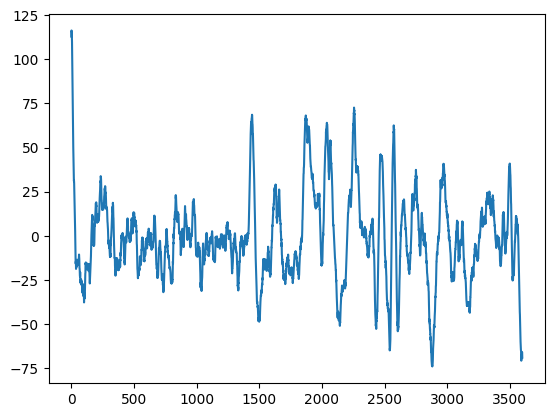

In [58]:
with zipfile.ZipFile(zip_file, mode="r") as f:
    with f.open(seg_file) as myfile:
        data = scipy.io.loadmat(myfile)['data'].squeeze()
print(data.shape)
plt.plot(data)

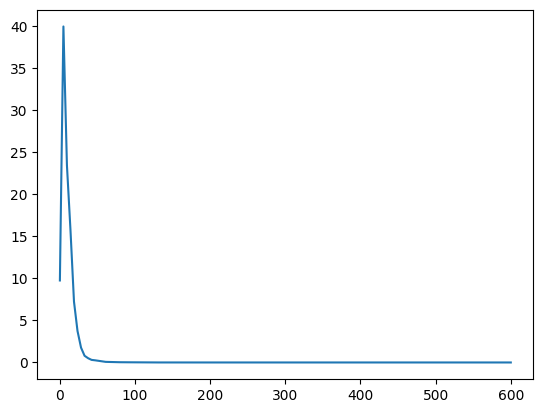

In [59]:
f, P = scipy.signal.welch(data, fs=1200)
# print(P)
plt.plot(f, P)

In [60]:
np.mean(data)

-1.2323151619439219

(3600,)


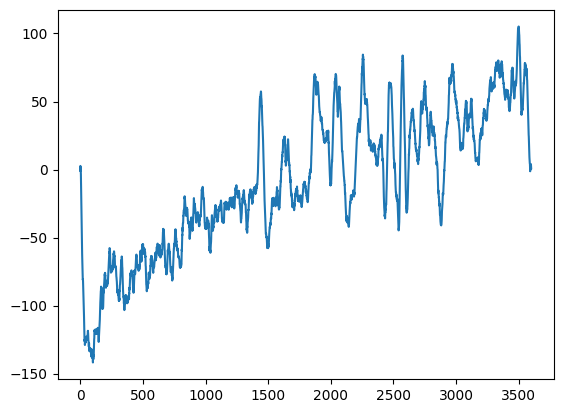

In [61]:
with zipfile.ZipFile('/home/mcesped/scratch/Datasets/Dataset_UFlorida_np.zip', mode="r") as f:
    with f.open(os.path.join(dir_name, 'x002000'+'.npy')) as myfile:
        data = np.load(myfile)
print(data.shape)
plt.plot(data)

In [55]:
np.mean(data)

49.181338555844604

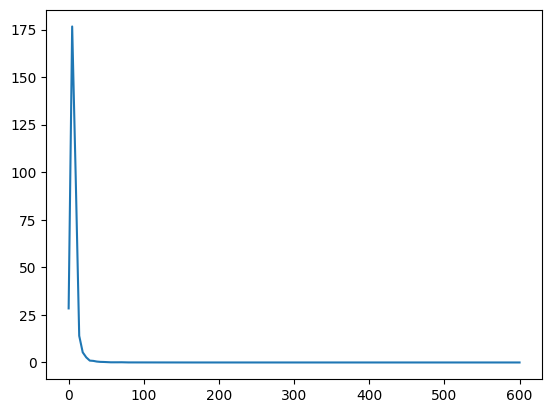

In [56]:
f, P = scipy.signal.welch(data, fs=1200)
plt.plot(f, P)

In [30]:
P

array([1.76967282e+01, 1.05782788e+02, 4.64284981e+01, 1.55295883e+01,
       6.62838466e+00, 3.41422533e+00, 1.07855105e+00, 4.49295299e-01,
       3.48675186e-01, 3.54553132e-01, 2.70432944e-01, 1.66981119e-01,
       7.34708073e-02, 5.31869018e-02, 4.53372378e-02, 4.49893764e-02,
       4.75347267e-02, 3.83907582e-02, 2.10955575e-02, 1.87872027e-02,
       2.10197907e-02, 1.99266512e-02, 1.62474871e-02, 1.43715688e-02,
       1.37336312e-02, 6.45424740e-03, 5.77745534e-03, 8.13983688e-03,
       7.56032871e-03, 6.25019615e-03, 7.12473068e-03, 6.94074109e-03,
       8.07069371e-03, 7.47820950e-03, 5.28368667e-03, 5.56168323e-03,
       6.03678610e-03, 4.81157650e-03, 2.56990558e-03, 2.63817832e-03,
       3.00184189e-03, 3.06595317e-03, 3.45578996e-03, 3.20736058e-03,
       3.04599898e-03, 3.50012204e-03, 2.65501780e-03, 3.47445782e-03,
       3.82177036e-03, 3.10462560e-03, 2.89630273e-03, 2.82395921e-03,
       3.64022307e-03, 3.56146923e-03, 3.43703867e-03, 3.68086104e-03,
      